In [1]:
import os
from typing import List, Tuple, Dict, Any, Optional
import cv2
import numpy as np
from tqdm import tqdm
import dlib
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
import matplotlib.cm as cm
from PIL import Image
import random
import shutil

In [78]:
# Global initialization for Dlib and MediaPipe
PREDICTOR_PATH = "../../eLearning/face_detection/weights/shape_predictor_68_face_landmarks.dat"  # Path to Dlib pre-trained model
detector_dlib = dlib.get_frontal_face_detector()
predictor_dlib = dlib.shape_predictor(PREDICTOR_PATH)
mp_face_mesh = mp.solutions.face_mesh
landmarks_68_indices = [
    162, 234, 93, 58, 172, 136, 149, 148, 152, 377, 378, 365, 397, 288, 323, 454, 389, 71, 63, 105, 66,
    107, 336, 296, 334, 293, 301, 168, 197, 5, 4, 75, 97, 2, 326, 305, 33, 160, 158, 133, 153, 144, 362,
    385, 387, 263, 373, 380, 61, 39, 37, 0, 267, 269, 291, 405, 314, 17, 84, 181, 78, 82, 13, 312, 308,
    317, 14, 87
]

def save_labels(output_label_path: str, labels: List[List[float]]) -> None:
    """
    Save labels in the required format: one line per detection, all coordinates on a single line.

    Args:
        output_label_path (str): Path to save the labels.
        labels (List[List[float]]): List of landmark coordinates per detection.
    """
    # Open the specified file in write mode
    with open(output_label_path, 'w') as file:
        # Iterate through each set of labels (one for each detection)
        for label in labels:
            # Write all coordinates as a single line, separated by spaces
            file.write(" ".join(map(str, label)) + "\n")

def plot_keypoints(image: np.ndarray, keypoints: List[Tuple[float, float]], output_path: str, 
                color: Tuple[int, int, int], min_radius: int = 8, max_radius: int = 16) -> None:
    """
    Plot keypoints on the image and save the result. The size of the keypoints adapts to the image resolution.

    Args:
        image (np.ndarray): Input image.
        keypoints (List[Tuple[float, float]]): List of (x, y) coordinates of keypoints.
        output_path (str): Path to save the plotted image.
        color (Tuple[int, int, int]): Color of the keypoints (B, G, R).
        min_radius (int): Minimum radius for keypoints.
        max_radius (int): Maximum radius for keypoints.
    """
    # Extract image dimensions (height, width, and channels)
    height, width, _ = image.shape
    # Calculate the diagonal length of the image to determine the proportional keypoint size
    image_diagonal = (width**2 + height**2) ** 0.5
    # Calculate radius based on 1% of the diagonal, constrained by min_radius and max_radius
    radius = max(min_radius, min(int(image_diagonal * 0.01), max_radius))
    # Thickness for the circles (-1 means filled circles)
    thickness = -1

    # Iterate over each keypoint (x, y) pair
    for x, y in keypoints:
        # Ensure x and y are integers for OpenCV functions
        x, y = int(x), int(y)
        # Check if the keypoint is within the image boundaries
        if 0 <= x < width and 0 <= y < height:
            # Draw a circle at the keypoint location on the image
            cv2.circle(image, (x, y), radius, color, thickness)

    # Save the image with the plotted keypoints
    cv2.imwrite(output_path, image)

def process_image_with_model(
    image: np.ndarray,
    model: str,
    output_image_path: str,
    output_label_path: str,
    normalize: bool = False
) -> bool:
    """
    Process an image with a specified model (Dlib or MediaPipe) to detect and save landmarks.

    Args:
        image (np.ndarray): Input image.
        model (str): Model to use ('dlib' or 'mediapipe').
        output_image_path (str): Path to save the image with landmarks.
        output_label_path (str): Path to save the landmark labels.
        normalize (bool): Whether to normalize the coordinates.

    Returns:
        bool: True if landmarks were detected, False otherwise.
    """
    # Extract the height and width of the image
    h, w = image.shape[:2]
    # Initialize empty lists for labels and keypoints
    labels = []
    keypoints = []

    if model == "dlib":
        # Convert the image to grayscale (Dlib works with grayscale images)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect faces in the image
        faces = detector_dlib(gray, 1)

        # Iterate over each detected face
        for face in faces:
            # Predict 68 facial landmarks for the detected face
            landmarks = predictor_dlib(gray, face)
            coords = []  # Temporary list to store coordinates for the current face
            # Extract each landmark (x, y) and optionally normalize
            for i in range(68):
                x = landmarks.part(i).x
                y = landmarks.part(i).y
                if normalize:
                    x, y = x / w, y / h  # Normalize based on image dimensions
                coords.extend([x, y])  # Add coordinates as [x, y]
                keypoints.append((x, y))  # Store for plotting
            labels.append(coords)  # Add all coordinates for the current face to labels

        # Set the color for plotting (blue for Dlib)
        color = (255, 0, 0)

    elif model == "mediapipe":
        # Convert the image to RGB (MediaPipe expects RGB format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Initialize MediaPipe's FaceMesh model
        with mp_face_mesh.FaceMesh(
            static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5
        ) as face_mesh:
            # Process the image to detect landmarks
            results = face_mesh.process(image_rgb)
            # If any landmarks are detected, iterate over them
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    coords = []  # Temporary list for the current face
                    # Extract and optionally normalize the 68 specified landmarks
                    for idx in landmarks_68_indices:
                        landmark = face_landmarks.landmark[idx]
                        x, y = (landmark.x, landmark.y) if normalize else (int(landmark.x * w), int(landmark.y * h))
                        coords.extend([x, y])
                        keypoints.append((x, y))  # Store for plotting
                    labels.append(coords)

        # Set the color for plotting (green for MediaPipe)
        color = (0, 255, 0)

    else:
        # Raise an error if an unsupported model is specified
        raise ValueError("Invalid model specified. Choose 'dlib' or 'mediapipe'.")

    # If landmarks were detected, save the results
    if labels:
        # Plot keypoints on the image and save it
        plot_keypoints(image.copy(), keypoints, output_image_path, color)
        # Save the landmark coordinates to a file
        save_labels(output_label_path, labels)
        return True  # Return True indicating successful detection

    return False  # Return False if no landmarks were detected

def process_images_in_directory(
    input_dir: str,
    dlib_output_dir: str,
    mediapipe_output_dir: str,
    normalize: bool = False
) -> None:
    """
    Process all images in a directory using Dlib and MediaPipe models.

    Args:
        input_dir (str): Directory containing input images.
        dlib_output_dir (str): Directory to save Dlib outputs.
        mediapipe_output_dir (str): Directory to save MediaPipe outputs.
        normalize (bool): Whether to normalize the coordinates.
    """
    # Create subdirectories for images and labels for both models
    os.makedirs(os.path.join(dlib_output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dlib_output_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(mediapipe_output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(mediapipe_output_dir, 'labels'), exist_ok=True)

    # Get a list of image files from the input directory
    images = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))]

    # Dictionary to store detection results for both models
    results = {"dlib": {"detected": 0, "not_detected": []}, "mediapipe": {"detected": 0, "not_detected": []}}

    # Process each model (Dlib and MediaPipe)
    for model, output_dir in [("dlib", dlib_output_dir), ("mediapipe", mediapipe_output_dir)]:
        print(f"\nProcessing with {model.capitalize()}...")
        # Iterate over all images
        for filename in tqdm(images, desc=f"{model.capitalize()} Progress"):
            # Construct the full image path
            image_path = os.path.join(input_dir, filename)
            # Read the image from disk
            image = cv2.imread(image_path)
            # Process the image with the specified model
            detected = process_image_with_model(
                image.copy(),
                model,
                output_image_path=os.path.join(output_dir, 'images', filename),
                output_label_path=os.path.join(output_dir, 'labels', f"{os.path.splitext(filename)[0]}.txt"),
                normalize=normalize
            )
            # Update detection results
            if detected:
                results[model]["detected"] += 1
            else:
                results[model]["not_detected"].append(filename)

    # Print a summary of detections for both models
    for model, res in results.items():
        print(f"\n=== {model.capitalize()} Detection Summary ===")
        print(f"Detected: {res['detected']} images.")
        if res["not_detected"]:
            print(f"Not detected: {len(res['not_detected'])} images:")
            print("\n".join(res["not_detected"]))



In [ ]:
input_directory = "/Users/jocareher/Downloads/baby_face_72_311/images"
dlib_predictions_dir = "dlib_predictions"
mediapipe_predictions_dir = "mediapipe_68_lmks_predictions"

process_images_in_directory(input_directory, dlib_predictions_dir, mediapipe_predictions_dir, normalize=False)


In [ ]:
def create_video_from_images(images: List[str], output_path: str, frame_rate: int = 30) -> None:
    """
    Creates a video from a list of image paths and overlays the image filename as a title on each frame.

    Args:
        images (List[str]): List of image file paths to include in the video.
        output_path (str): The output path for the generated video file.
        frame_rate (int): The frame rate (frames per second) of the video.
    """
    if not images:
        print("No images provided for video generation.")
        return

    # Read the first image to get the frame size
    first_image = cv2.imread(images[0])
    if first_image is None:
        print(f"Error: Unable to read {images[0]}")
        return
    height, width, _ = first_image.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    # Loop through all images and write each one to the video
    for idx, image_path in enumerate(images):
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Warning: Unable to read {image_path}, skipping.")
            continue

        # Confirm that frame size matches the first image (for consistency in the video)
        if frame.shape[0] != height or frame.shape[1] != width:
            print(f"Warning: Image {image_path} has a different size, resizing.")
            frame = cv2.resize(frame, (width, height))
        
        # Get the base filename (without path) to display on the frame
        image_name = os.path.basename(image_path)
        
        # Set font properties
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 0)  # White color
        font_thickness = 2
        text_position = (50, 50)  # Position to display the filename (x, y)

        # Add the filename text to the frame
        cv2.putText(frame, image_name, text_position, font, font_scale, font_color, font_thickness, cv2.LINE_AA)
        
        # Write the current frame to the video
        video_writer.write(frame)
        print(f"Added frame {idx + 1}/{len(images)}: {image_path}")

    # Release the video writer once the video is completed
    video_writer.release()
    print(f"Video saved at {output_path}")

def collect_images_by_orientation(root_dir: str) -> dict:
    """
    Collects images from all subdirectories in the root directory and categorizes them by orientation.

    Args:
        root_dir (str): The root directory containing subdirectories with images.

    Returns:
        dict: A dictionary where the keys are orientations ('frontal', 'left', etc.) and
              the values are lists of image paths.
    """
    orientation_dict = {
        'frontal': [],
        'left': [],
        'right': [],
        'quarter_left': [],
        'quarter_right': []
    }

    # Traverse the root directory and all subdirectories
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg') and 'with_landmarks' not in file:
                # Determine orientation based on the filename
                if 'frontal' in file:
                    orientation_dict['frontal'].append(os.path.join(subdir, file))
                elif 'left' in file and 'quarter' not in file:
                    orientation_dict['left'].append(os.path.join(subdir, file))
                elif 'right' in file and 'quarter' not in file:
                    orientation_dict['right'].append(os.path.join(subdir, file))
                elif 'quarter_left' in file:
                    orientation_dict['quarter_left'].append(os.path.join(subdir, file))
                elif 'quarter_right' in file:
                    orientation_dict['quarter_right'].append(os.path.join(subdir, file))

    # Sort images by name to ensure they are in correct sequence
    for orientation, image_list in orientation_dict.items():
        orientation_dict[orientation] = sorted(image_list)

    return orientation_dict

def create_videos_for_all_orientations(root_dir: str, output_dir: str, frame_rate: int = 30) -> None:
    """
    Creates videos for each orientation from the images in all subdirectories of the root directory.

    Args:
        root_dir (str): The root directory containing subdirectories with images.
        output_dir (str): The output directory where the videos will be saved.
        frame_rate (int): The frame rate (frames per second) of the video.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Collect all images categorized by orientation from all subdirectories
    images_by_orientation = collect_images_by_orientation(root_dir)

    # Create a video for each orientation
    for orientation, images in images_by_orientation.items():
        print(images)
        if images:
            output_path = os.path.join(output_dir, f"{orientation}.mp4")
            create_video_from_images(images, output_path, frame_rate)
        else:
            print(f"No images found for {orientation} orientation.")

In [ ]:
def convert_pts_to_yolo_format(pts_file_path: str, image_file_path: str, output_txt_path: str, normalize: bool = True, has_visibility: bool = False, modify_visibility: bool = False) -> None:
    """
    Converts a .pts file containing landmarks to a YOLOv8 format (x1 y1 visibility ... xn yn visibility),
    with an option to normalize the coordinates based on the image dimensions and optionally modify visibility values.

    Args:
        pts_file_path (str): The path to the .pts file to be converted.
        image_file_path (str): The path to the corresponding image file to get dimensions for normalization.
        output_txt_path (str): The path to save the converted .txt file in YOLOv8 format.
        normalize (bool): Whether to normalize the coordinates based on image size. Defaults to True.
        has_visibility (bool): Whether the .pts file includes visibility information (0 or 1). Defaults to False.
        modify_visibility (bool): If True, converts visibility values from 0 to 1 and 1 to 2. Defaults to False.
    """
    # Read image dimensions
    image = cv2.imread(image_file_path)
    if image is None:
        print(f"Error: Could not read the image {image_file_path}")
        return
    height, width = image.shape[:2]

    with open(pts_file_path, 'r') as pts_file:
        lines = pts_file.readlines()

    # We will skip the first two lines and extract only the coordinates
    coordinates = []
    for line in lines[2:]:  # Skip "Version" and number of points
        parts = line.split()
        if len(parts) >= 3:
            # Extract x, y coordinates (skip the label 'SXXXX')
            x, y = float(parts[1]), float(parts[2])

            # Normalize coordinates if the flag is set to True
            if normalize:
                x /= width
                y /= height

            # Handle visibility if has_visibility is True
            if has_visibility and len(parts) > 3:
                visibility = int(parts[3])
                if modify_visibility:
                    visibility = 1 if visibility == 0 else 2  # Modify visibility as requested
                coordinates.append(f"{x} {y} {visibility}")
            else:
                coordinates.append(f"{x} {y}")

    # Write the coordinates in YOLOv8 format (single line)
    with open(output_txt_path, 'w') as txt_file:
        txt_file.write(' '.join(coordinates) + '\n')

    print(f"Converted {pts_file_path} to YOLOv8 format at {output_txt_path}")


def process_pts_directory_for_yolo(root_directory: str, output_directory: str, normalize: bool = True, has_visibility: bool = False, modify_visibility: bool = False) -> None:
    """
    Processes all .pts files in the root directory and its subdirectories, converts them to YOLOv8 format,
    normalizing the coordinates based on image dimensions if specified, and saves the output
    in the corresponding subdirectory in the output directory.

    Args:
        root_directory (str): The root directory containing subdirectories with .pts files and images.
        output_directory (str): The root directory where the converted .txt files will be saved in YOLOv8 format.
        normalize (bool): Whether to normalize the coordinates based on image size. Defaults to True.
        has_visibility (bool): Whether the .pts files include visibility information (0 or 1). Defaults to False.
        modify_visibility (bool): If True, modifies visibility values (0->1 and 1->2). Defaults to False.
    """
    # Traverse all subdirectories in the root directory
    for subdir, _, files in os.walk(root_directory):
        # Create a corresponding subdirectory in the output directory
        relative_path = os.path.relpath(subdir, root_directory)
        output_subdir = os.path.join(output_directory, relative_path)
        os.makedirs(output_subdir, exist_ok=True)

        for filename in files:
            if filename.endswith('.pts'):
                # Get corresponding image file with the same base name
                base_name = filename.replace('.pts', '')
                image_file_path = os.path.join(subdir, base_name + '.jpg')
                
                # Check if the corresponding image file exists
                if not os.path.exists(image_file_path):
                    print(f"Warning: Image {image_file_path} not found for {filename}, skipping.")
                    continue

                pts_file_path = os.path.join(subdir, filename)
                output_txt_path = os.path.join(output_subdir, filename.replace('.pts', '.txt'))

                # Convert .pts to YOLOv8 format, normalizing coordinates based on the image size
                convert_pts_to_yolo_format(pts_file_path, image_file_path, output_txt_path, normalize, has_visibility, modify_visibility)

                print(f"Processed {filename}: saved as {output_txt_path}")


In [ ]:
# FIRST STEP
root_dir = "/Users/jocareher/Documents/synthetic_images_train"
output_dir = "/Users/jocareher/Documents/pts_to_txt_vis_12"
process_pts_directory_for_yolo(root_directory=root_dir,
                               output_directory=output_dir,
                               has_visibility=True,
                               modify_visibility=True)

Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_frontal.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_frontal.txt
Processed synthetic_shape_01711_frontal.pts: saved as /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_frontal.txt
Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_right.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_right.txt
Processed synthetic_shape_01711_right.pts: saved as /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_right.txt
Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_quarter_left.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_

In [ ]:
def plot_landmarks_on_image(image_path: str, txt_path: str, normalized: bool = True) -> None:
    """
    Plots landmarks from a YOLOv8-formatted .txt file onto an image and displays the result using matplotlib.

    Args:
        image_path (str): The path to the image file.
        txt_path (str): The path to the .txt file containing landmarks in YOLOv8 format.
        normalized (bool): Whether the coordinates in the .txt file are normalized (in the range [0, 1]).
                           Defaults to True.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read the image {image_path}")
        return
    # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]

    # Read the coordinates from the .txt file
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
        coordinates = list(map(float, line.split()))

    # Ensure that we have an even number of coordinates (x, y pairs)
    if len(coordinates) % 2 != 0:
        print(f"Error: Mismatched number of coordinates in {txt_path}")
        return

    # Plot each landmark point on the image
    for i in range(0, len(coordinates), 2):
        x, y = coordinates[i], coordinates[i + 1]

        # If the coordinates are normalized, denormalize them
        if normalized:
            x = int(x * width)
            y = int(y * height)

        # Draw the point on the image (green dot)
        cv2.circle(image_rgb, (int(x), int(y)), 3, (0, 255, 0), 2)

    # Display the image with landmarks using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [ ]:
def contains_nan(txt_file_path: str) -> bool:
    """
    Checks if the given .txt file contains any NaN values in the coordinates.

    Args:
        txt_file_path (str): Path to the .txt file containing coordinates.

    Returns:
        bool: True if the file contains NaN values, False otherwise.
    """
    with open(txt_file_path, 'r') as f:
        line = f.readline().strip()
        coordinates = line.split()

    # Convert all values to float and check if any are NaN
    coordinates = [float(value) for value in coordinates]
    return any(np.isnan(coordinates))


def organize_images_and_labels(image_root: str, label_root: str, output_root: str) -> None:
    """
    Organizes images and labels by copying all valid pairs (no NaN in labels) to a single directory with 'images' and 'labels' subdirectories.
    Images and labels with NaN values are left in their original locations.

    Args:
        image_root (str): The root directory containing subdirectories with images.
        label_root (str): The root directory containing subdirectories with .txt label files.
        output_root (str): The root directory where 'images' and 'labels' subdirectories will be created for valid files.
    """
    # Create output directories for images and labels if they don't exist
    output_image_dir = os.path.join(output_root, "images")
    output_label_dir = os.path.join(output_root, "labels")
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for subdir, _, files in os.walk(label_root):
        for label_file in files:
            if label_file.endswith('.txt'):
                # Determine corresponding image path based on the label file
                label_file_path = os.path.join(subdir, label_file)
                image_file_name = label_file.replace('.txt', '.jpg')
                
                # Build image file path by mapping the label directory structure to the image_root
                relative_subdir = os.path.relpath(subdir, label_root)
                image_file_path = os.path.join(image_root, relative_subdir, image_file_name)
                
                # Check if both the image and label file exist
                if os.path.exists(image_file_path) and os.path.exists(label_file_path):
                    if contains_nan(label_file_path):
                        print(f"NaN found in {label_file}, leaving in original location.")
                        # Leave the image and label in the original location
                    else:
                        # Move the valid image and label to the respective directories under output_root
                        shutil.copy(image_file_path, os.path.join(output_image_dir, image_file_name))
                        shutil.copy(label_file_path, os.path.join(output_label_dir, label_file))
                        print(f"Copied {image_file_name} and {label_file} to {output_image_dir} and {output_label_dir}.")


In [ ]:
# SECOND STEP
image_root = "/Users/jocareher/Documents/synthetic_images_train"
label_root = "/Users/jocareher/Documents/pts_to_txt_vis_12"
dataset_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12"
organize_images_and_labels(image_root,
                           label_root,
                           dataset_dir)

Copied synthetic_shape_01711_right.jpg and synthetic_shape_01711_right.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_frontal.jpg and synthetic_shape_01711_frontal.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_quarter_left.jpg and synthetic_shape_01711_quarter_left.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_quarter_right.jpg and synthetic_shape_01711_quarter_right.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_left.jpg and synthetic_shape_01711_left.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_

In [ ]:
def get_class_index(filename: str) -> int:
    """
    Returns the class index based on the filename.

    Args:
        filename (str): The name of the file (without directory path).

    Returns:
        int: The corresponding class index.
    """
    if 'quarter_left' in filename:
        return 0
    elif 'quarter_right' in filename:
        return 1
    elif 'frontal' in filename:
        return 2
    elif 'left' in filename:
        return 3
    elif 'right' in filename:
        return 4
    else:
        raise ValueError(f"Filename '{filename}' does not match any expected orientation.")


def add_class_index_to_landmarks_labels(txt_dir: str, include_bbox: bool = True) -> None:
    """
    Reads all .txt files in the directory and adds a class index to each file based on its filename.
    Optionally, also adds 0 0 0 0 to the bounding box fields.

    Args:
        txt_dir (str): The directory containing the .txt files.
        include_bbox (bool): Whether to add 0 0 0 0 as the bounding box values. Defaults to True.
    """
    # Process each .txt file in the directory
    for txt_file in os.listdir(txt_dir):
        if txt_file.endswith('.txt'):
            txt_file_path = os.path.join(txt_dir, txt_file)

            # Get the class index based on the filename
            class_index = get_class_index(txt_file)

            # Read the existing coordinates from the file
            with open(txt_file_path, 'r') as f:
                coordinates = f.readline().strip()

            # If include_bbox is True, prepend the class index and "0 0 0 0" for the bounding box
            if include_bbox:
                updated_content = f"{class_index} 0 0 0 0 {coordinates}"
            else:
                # Only prepend the class index without bounding box values
                updated_content = f"{class_index} {coordinates}"

            # Write the updated content back to the file
            with open(txt_file_path, 'w') as f:
                f.write(updated_content)
            
            print(f"Updated {txt_file} with class index {class_index} and bounding box {include_bbox}.")

In [ ]:
# THIRD STEP
txt_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12/labels"
add_class_index_to_landmarks_labels(txt_dir,
                                    False)

Updated synthetic_shape_00264_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_01840_quarter_left.txt with class index 0 and bounding box False.
Updated synthetic_shape_00787_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_00507_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_01185_left.txt with class index 3 and bounding box False.
Updated synthetic_shape_01315_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_00057_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_01645_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_00855_quarter_right.txt with class index 1 and bounding box False.
Updated synthetic_shape_00028_quarter_right.txt with class index 1 and bounding box False.
Updated synthetic_shape_00052_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_00578_right.txt with class index 

In [ ]:
def count_landmark_visibility_by_orientation(root_dir):
    """
    Counts the number of visible and occluded landmarks in the dataset,
    grouped by orientation (class index) and partition (train, val, test).
    
    Args:
        root_dir (str): Path to the root directory containing "train", "val", and "test" subdirectories,
                        each with "labels" subdirectory.
    """
    # Definir las particiones y las clases
    partitions = ['train', 'val', 'test']
    orientations = {
        0: "quarter_left",
        1: "quarter_right",
        2: "frontal",
        3: "left",
        4: "right"
    }
    
    # Diccionario para almacenar los conteos
    visibility_counts = {
        partition: {orientation: {"visible": 0, "occluded": 0} for orientation in orientations.values()}
        for partition in partitions
    }
    
    # Recorrer cada partición y contar la visibilidad
    for partition in partitions:
        labels_dir = os.path.join(root_dir, partition, 'labels')
        if not os.path.exists(labels_dir):
            print(f"Warning: {labels_dir} not found, skipping.")
            continue

        # Procesar cada archivo .txt en la carpeta de labels
        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(labels_dir, label_file)
                with open(label_path, 'r') as file:
                    lines = file.readlines()

                    # Leer la primera línea para obtener la clase (orientación)
                    if not lines:
                        continue  # Saltar archivos vacíos
                    first_line = lines[0].strip().split()
                    class_idx = int(first_line[0])
                    orientation = orientations.get(class_idx, "Unknown")

                    # Contar los flags de visibilidad
                    for line in lines:
                        parts = line.strip().split()[5:]  # Omitir class_idx y bbox (cx, cy, w, h)
                        for i in range(2, len(parts), 3):  # Leer cada flag de visibilidad
                            visibility_flag = int(parts[i])
                            if visibility_flag == 1:
                                visibility_counts[partition][orientation]["occluded"] += 1
                            elif visibility_flag == 2:
                                visibility_counts[partition][orientation]["visible"] += 1
    
    # Mostrar el resultado
    for partition, counts in visibility_counts.items():
        print(f"\n{partition.capitalize()} set landmarks visibility distribution")
        print("----------")
        for orientation, count in counts.items():
            print(f"{orientation}:")
            print(f"visible = {count['visible']}")
            print(f"occluded = {count['occluded']}")
            print(f"total lmks = {count['occluded'] + count['visible']}")
            print(f"----------")

root_directory = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset"
count_landmark_visibility_by_orientation(root_directory)


Train set landmarks visibility distribution
----------
quarter_left:
visible = 96037
occluded = 19019
total lmks = 115056
----------
quarter_right:
visible = 95921
occluded = 19135
total lmks = 115056
----------
frontal:
visible = 97487
occluded = 17713
total lmks = 115200
----------
left:
visible = 66563
occluded = 48349
total lmks = 114912
----------
right:
visible = 64751
occluded = 49153
total lmks = 113904
----------

Val set landmarks visibility distribution
----------
quarter_left:
visible = 11982
occluded = 2346
total lmks = 14328
----------
quarter_right:
visible = 11927
occluded = 2401
total lmks = 14328
----------
frontal:
visible = 12218
occluded = 2182
total lmks = 14400
----------
left:
visible = 8266
occluded = 6062
total lmks = 14328
----------
right:
visible = 8061
occluded = 6123
total lmks = 14184
----------

Test set landmarks visibility distribution
----------
quarter_left:
visible = 12081
occluded = 2391
total lmks = 14472
----------
quarter_right:
visible = 1212

In [4]:
def prepare_lmks_test_set(root_dir, csv_path, output_dir):
    """
    Prepares the test set with landmarks in a single line format per face without visibility flag.
    
    Parameters:
    - root_dir (str): Root directory containing the image folders.
    - csv_path (str): Path to the CSV file containing the labels.
    - output_dir (str): Directory where the test set will be created.
    
    Returns:
    None
    """
    # Create necessary output directories
    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Filter the test set: Include only images from google and youtube subsets
    test_set = df[df['image-set'].isin(['google', 'youtube'])]
    
    for _, row in test_set.iterrows():
        # Locate the image file
        image_path = os.path.join(root_dir, 'images', row['image-set'], row['filename'])
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        
        # Copy the image to the output directory
        shutil.copy(image_path, os.path.join(images_dir, row['filename']))
        
        # Extract landmarks as a single line
        landmarks = []
        for i in range(68):  # 68 landmarks
            x = row[f'gt-x{i}']
            y = row[f'gt-y{i}']
            if not pd.isna(x) and not pd.isna(y):  # Check for valid coordinates
                landmarks.extend([x, y])
        
        # Save landmarks in single line format to a .txt file
        label_filename = f"{os.path.splitext(row['filename'])[0]}.txt"
        label_path = os.path.join(labels_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write(" ".join(map(str, landmarks)) + "\n")
        
        # Generate and save plot with landmarks
        generate_landmark_plots(image_path, landmarks, os.path.join(plots_dir, row['filename']))

def generate_landmark_plots(image_path, landmarks, output_path, min_radius=1, max_radius=5, color=(0, 0, 255)):
    """
    Generates a plot of the landmarks overlaid on the original image with dynamic landmark size.
    
    Parameters:
    - image_path (str): Path to the image file.
    - landmarks (list): List of (x, y) tuples representing the landmark coordinates.
    - output_path (str): Path to save the plotted image.
    - min_radius (int): Minimum radius for the landmarks.
    - max_radius (int): Maximum radius for the landmarks.
    - color (tuple): Color of the landmarks (B, G, R).
    
    Returns:
    None
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image: {image_path}")
        return
    
    # Calculate the diagonal of the image to determine proportional landmark size
    height, width, _ = image.shape
    image_diagonal = (width**2 + height**2) ** 0.5

    # Calculate dynamic radius for the landmarks
    radius = max(int(image_diagonal * 0.0025), min_radius)  # Ensure a minimum size
    radius = min(radius, max_radius)  # Cap at maximum size
    thickness = -1  # Fill the circles

    # Draw landmarks on the image
    for i in range(0, len(landmarks), 2):  # Iterate over landmarks (x, y)
        x, y = landmarks[i], landmarks[i + 1]
        cv2.circle(image, (int(x), int(y)), radius, color, thickness)
    
    # Save the image with landmarks
    cv2.imwrite(output_path, image)


prepare_lmks_test_set(
    root_dir='/Users/jocareher/Downloads/infanface-public/',  # Replace with the actual root directory
    csv_path='/Users/jocareher/Downloads/infanface-public/labels.csv',
    output_dir='/Users/jocareher/Downloads/lmks_test_set'
)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


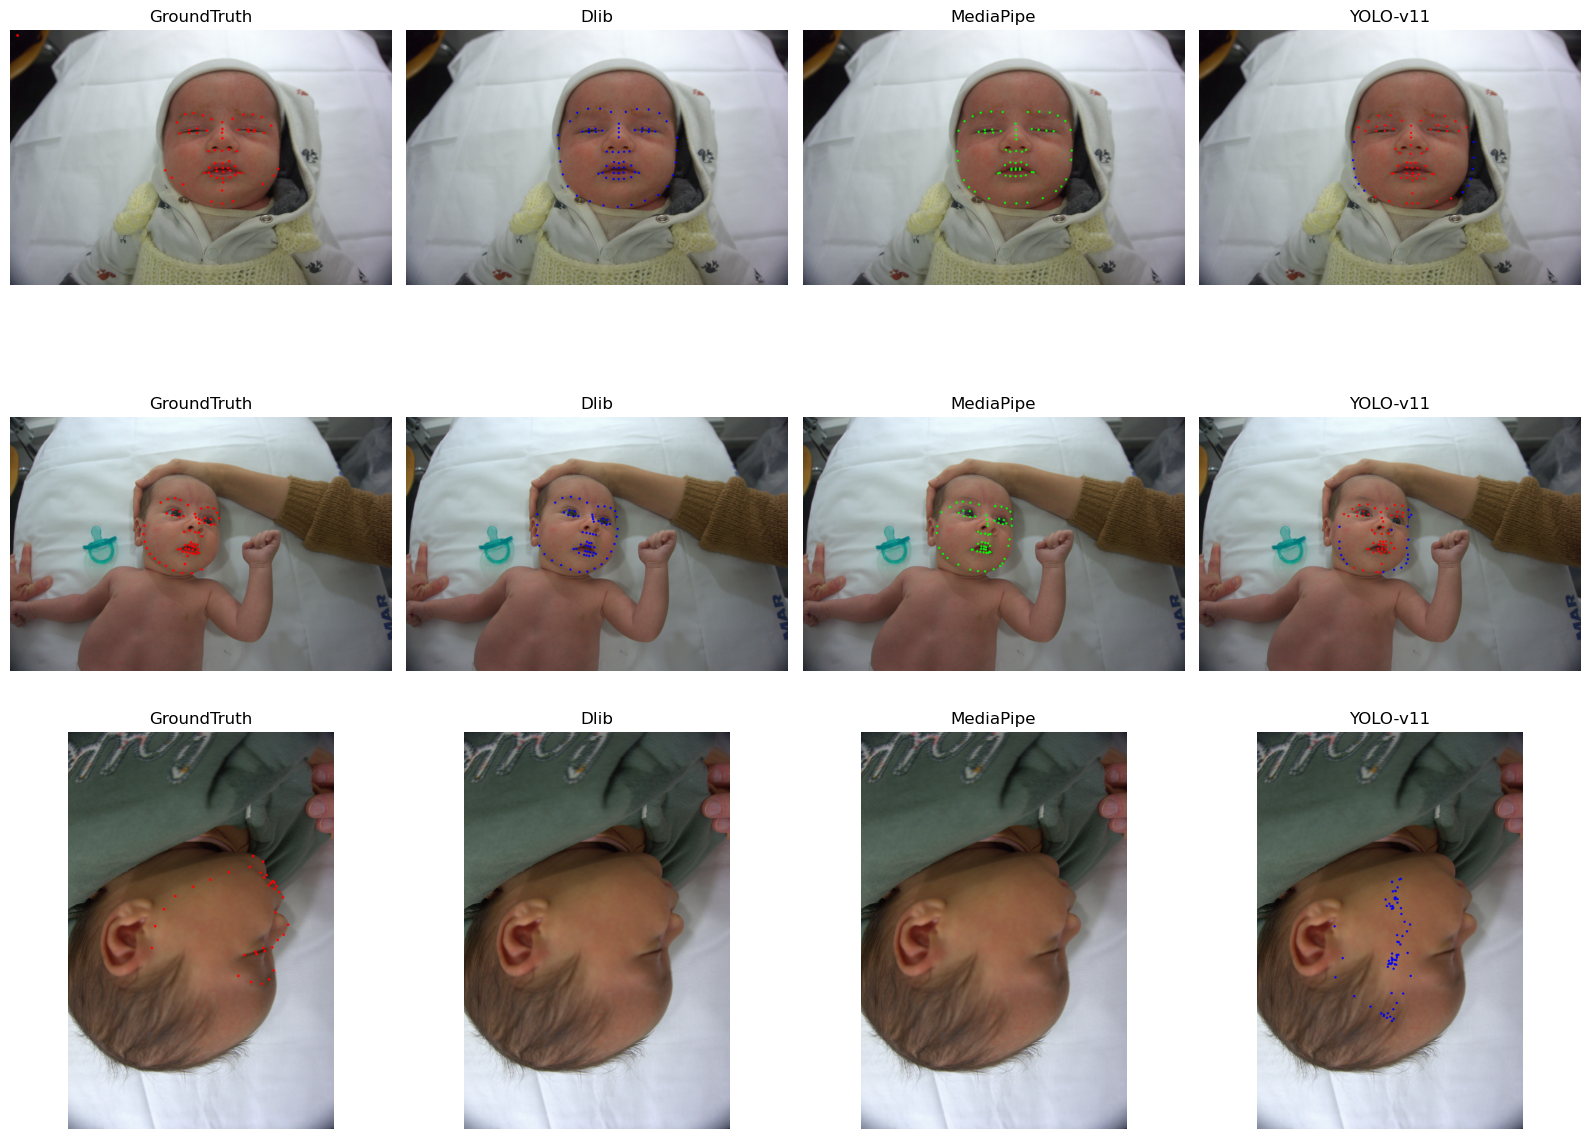

In [17]:
def dynamic_comparison_grid(directories, output_path, grid_size=(3, 4)):
    """
    Creates a grid of images for visual comparison of landmarks generated by different models.

    Args:
        directories (dict): A dictionary where keys are titles (e.g., 'GroundTruth', 'Dlib') and values are paths to directories containing images.
        output_path (str): Path to save the resulting grid image.
        grid_size (tuple): The number of rows and columns for the grid (default: 3x4).

    Returns:
        None
    """
    # Step 1: Filter image files for each directory
    filtered_files = {
        title: sorted([f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        for title, dir_path in directories.items()
    }

    # Step 2: Find common files across all directories
    common_files = set.intersection(*[set(files) for files in filtered_files.values()])
    common_files = sorted(common_files)  # Sort files for consistent order

    if not common_files:
        print("No common files found across the directories.")
        return

    # Step 3: Shuffle and select files for the grid
    random.shuffle(common_files)
    num_rows = grid_size[0]  # Number of rows
    files_to_display = common_files[:num_rows]

    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    # Step 4: Display each row with images from all directories
    for row_idx, file_name in enumerate(files_to_display):
        if row_idx * len(directories) >= len(axs):
            break

        # Load images from all directories for the current file
        images = [
            Image.open(os.path.join(dir_path, file_name))
            for dir_path in directories.values()
        ]
        titles = list(directories.keys())

        # Display images in the corresponding subplot
        for col_idx, (img, title) in enumerate(zip(images, titles)):
            ax_index = row_idx * len(directories) + col_idx
            if ax_index >= len(axs):
                break
            ax = axs[ax_index]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(title)

    # Step 5: Hide unused subplots
    used_subplots = len(files_to_display) * len(directories)
    for ax in axs[used_subplots:]:
        ax.axis('off')

    # Step 6: Final layout adjustments and save
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Example usage
directories = {
    "GroundTruth": "/path/to/gt_dir",
    "Dlib": "/path/to/dlib_dir",
    "MediaPipe": "/path/to/mediapipe_dir",
    "YOLO-v11": "/path/to/yolo_dir",
    # Add more directories if needed
}

# Generate a grid with 3 rows and 4 columns
output_path = "/path/to/output_grid.png"
dynamic_comparison_grid(directories, output_path, grid_size=(3, 4))


In [77]:
# -----------------------------
# 1. Constants and Mapping
# -----------------------------
NUM_LANDMARKS = 72
# For ground-truth, we expect exactly 72 * 2 = 144 floats
EXPECTED_GT_VALUES = NUM_LANDMARKS * 2
# For your model's predictions, we expect exactly 72 * 3 = 216 floats
EXPECTED_PRED_VALUES = NUM_LANDMARKS * 3

def create_landmark_mapping() -> List[int]:
    """
    Returns a list of length 72 that reorders the predicted 72 landmarks into
    the matching ground-truth indexing. Modify if your final mapping differs.
    """
    # Example based on your snippet
    raw_mapping = {
        0: 19, 1: 20, 2: 23, 3: 24, 4: 25, 5: 26, 6: 27, 7: 28, 8: 29, 9: 30,
        10: 31, 11: 32, 12: 33, 13: 34, 14: 35, 15: 22, 16: 21, 17: 36, 18: 37,
        19: 38, 20: 39, 21: 40, 22: 2, 23: 41, 24: 42, 25: 43, 26: 44, 27: 45,
        28: 0, 29: 48, 30: 49, 31: 1, 32: 3, 33: 52, 34: 53, 35: 4, 36: 51,
        37: 50, 38: 55, 39: 54, 40: 46, 41: 47, 42: 7, 43: 6, 44: 5, 45: 10,
        46: 9, 47: 8, 48: 11, 49: 56, 50: 12, 51: 13, 52: 14, 53: 57, 54: 15,
        55: 62, 56: 63, 57: 64, 58: 65, 59: 66, 60: 69, 61: 68, 62: 67, 63: 61,
        64: 60, 65: 16, 66: 59, 67: 58
    }
    # Sort by the dictionary's value to get the final "destination" ordering
    final_map = [v for _, v in sorted(raw_mapping.items(), key=lambda x: x[1])]
    if len(final_map) < NUM_LANDMARKS:
        while len(final_map) < NUM_LANDMARKS:
            final_map.append(final_map[-1])
    elif len(final_map) > NUM_LANDMARKS:
        final_map = final_map[:NUM_LANDMARKS]

    if len(final_map) != NUM_LANDMARKS:
        raise ValueError(f"The final mapping does not have {NUM_LANDMARKS} elements.")

    return final_map

# ================================
# 1. Universal Constants & Helpers
# ================================
def load_landmarks_txt(
    file_path: str,
    num_landmarks: int,
    floats_per_lmk: int,
    allow_multiple_faces: bool = True,
    trim_excess: bool = True
) -> Optional[np.ndarray]:
    """
    General loader for a .txt file containing face landmarks.
    
    Each line in the file is considered a separate "face" if allow_multiple_faces=True.
    Otherwise, only the first line is used.

    - Expects each face to have num_landmarks * floats_per_lmk floats.
    - If a line has fewer floats, the file is treated as invalid.
    - If there are more floats and trim_excess=True, extra floats are trimmed.
    - Only (x, y) is stored, ignoring any additional floats (for example, visibility).

    Args:
        file_path (str): Path to the .txt file.
        num_landmarks (int): The total number of landmarks (for example, 68 or 72).
        floats_per_lmk (int): Number of floats per landmark (for example, 2 for (x, y), 3 for (x, y, visibility)).
        allow_multiple_faces (bool): Indicates whether to load all lines as separate faces. If False, only the first line is used.
        trim_excess (bool): If True, lines with extra floats are trimmed to the expected amount.

    Returns:
        np.ndarray of shape (num_faces, num_landmarks, 2) if the file is valid and non-empty.
        None if the file is empty, missing, or invalid.
    """
    # Expected total floats for each face
    expected_floats = num_landmarks * floats_per_lmk

    # Check if the file exists and is non-empty
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        return None  # empty or missing file

    # Read all lines
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    if not lines:
        return None
    
    # Keep only the first line if multiple faces are not allowed
    if not allow_multiple_faces:
        lines = lines[:1]  # keep only the first line if multiple faces are not allowed

    all_faces = []
    
    # Process each line
    for line in lines:
        # Split by whitespace and remove leading/trailing spaces
        coords_str = line.strip().split()
        if len(coords_str) < expected_floats:
            # Not enough floats for a full face
            return None
        elif len(coords_str) > expected_floats and trim_excess:
            # Trim extra floats
            coords_str = coords_str[:expected_floats]

        try:
            # Convert to floats
            floats = list(map(float, coords_str))
        except ValueError:
            continue  # skip this line if it has invalid floats

        # Build (x, y) pairs, ignoring extra floats (for example, visibility)
        face_points = []
        for i in range(num_landmarks):
            # Each landmark has 'floats_per_lmk' floats
            base_idx = i * floats_per_lmk
            x = floats[base_idx + 0]
            y = floats[base_idx + 1]
            face_points.append((x, y))
            
        # Store the face landmarks
        face_points = np.array(face_points, dtype=float)
        if face_points.shape != (num_landmarks, 2):
            continue
        
        all_faces.append(face_points)

    if not all_faces:
        return None

    return np.array(all_faces)


def compute_iod(landmarks: np.ndarray, left_eye_idx: int, right_eye_idx: int) -> float:
    """
    Computes the inter-ocular distance given 2D landmarks and the indices for
    the left and right eye corners. Returns np.nan if invalid.

    Args:
        landmarks (np.ndarray): Array of shape (N, 2) containing (x, y) landmarks.
        left_eye_idx (int): Index of the left-eye corner.
        right_eye_idx (int): Index of the right-eye corner.

    Returns:
        float: Euclidean distance between the two specified eye corners, or np.nan if invalid.
    """
    # Check if the indices are within the valid range
    if landmarks.shape[0] <= max(left_eye_idx, right_eye_idx):
        return np.nan
    # Get the landmark coordinates
    left_eye = landmarks[left_eye_idx]
    right_eye = landmarks[right_eye_idx]
    # Check for NaN values
    if np.isnan(left_eye).any() or np.isnan(right_eye).any():
        return np.nan
    # Compute the Euclidean distance
    return np.linalg.norm(left_eye - right_eye)


def compute_box(landmarks: np.ndarray) -> float:
    """
    Computes the bounding-box size as sqrt(width * height) for all valid (non-nan) points.

    Args:
        landmarks (np.ndarray): Array of shape (N, 2) containing (x, y) landmarks.

    Returns:
        float: Bounding-box factor or np.nan if no valid points or zero area.
    """
    # Filter out NaN values
    valid_pts = landmarks[~np.isnan(landmarks).any(axis=1)]
    # Check if there are any valid points
    if len(valid_pts) == 0:
        return np.nan
    
    # Compute the bounding box
    x_min, y_min = np.min(valid_pts, axis=0)
    x_max, y_max = np.max(valid_pts, axis=0)
    width = x_max - x_min
    height = y_max - y_min
    
    # Check for zero area
    if width <= 0 or height <= 0:
        return np.nan
    return np.sqrt(width * height)


def compute_nme(
    pred_landmarks: np.ndarray,
    gt_landmarks: np.ndarray,
    normalization_factor: float
) -> float:
    """
    Computes the normalized mean error (NME) for a single face, using only indices
    where ground-truth landmarks are valid. Divides the mean distance by the given factor.

    Args:
        pred_landmarks (np.ndarray): Predicted landmarks of shape (N, 2).
        gt_landmarks (np.ndarray): Ground-truth landmarks of shape (N, 2).
        normalization_factor (float): Divisor for normalization (IOD or bounding-box factor).

    Returns:
        float: The mean distance over valid landmarks, normalized by the factor. np.nan if invalid.
    """
    # Check for invalid shapes or normalization factor
    if pred_landmarks.shape != gt_landmarks.shape:
        return np.nan
    # Check for invalid normalization factor
    if normalization_factor <= 0:
        return np.nan
    # Find valid indices where GT landmarks are not NaN
    valid_idx = ~np.isnan(gt_landmarks).any(axis=1)
    if not np.any(valid_idx):
        return np.nan
    # Compute the Euclidean distances
    distances = np.linalg.norm(pred_landmarks[valid_idx] - gt_landmarks[valid_idx], axis=1)
    return np.mean(distances) / normalization_factor


# ===================================
# 2. Unified Evaluation Function
# ===================================
def evaluate_nme(
    pred_dir: str,
    gt_dir: str,
    num_landmarks: int,
    floats_per_lmk_pred: int,
    floats_per_lmk_gt: int = 2,
    allow_multi_face: bool = True,
    left_eye_idx: int = 36,
    right_eye_idx: int = 45,
    mapping: Optional[List[int]] = None
) -> Dict[str, Any]:
    """
    Evaluates NME (IOD and BOX) for a set of ground-truth .txt files in 'gt_dir' and 
    matching prediction .txt files in 'pred_dir', keyed by exact filename match.

    Args:
        pred_dir (str): Path to prediction .txt files.
        gt_dir (str): Path to ground-truth .txt files.
        num_landmarks (int): Number of landmarks (e.g., 68 or 72).
        floats_per_lmk_pred (int): Floats per predicted landmark (2 for x,y or 3 for x,y,visibility).
        floats_per_lmk_gt (int): Floats per ground-truth landmark (usually 2).
        allow_multi_face (bool): If True, each .txt file can contain multiple lines (faces). Otherwise, only one line is processed.
        left_eye_idx (int): Index for the left-eye corner (for IOD).
        right_eye_idx (int): Index for the right-eye corner (for IOD).
        mapping (Optional[List[int]]): If provided, reorders predicted landmarks to match the GT order.

    Returns:
        Dict[str, Any]:
            {
                "nme_iod_list": List of IOD-normalized errors for all valid faces
                "nme_box_list": List of BOX-normalized errors
                "avg_nme_iod": Mean IOD-based NME or None if no valid data
                "avg_nme_box": Mean BOX-based NME or None if no valid data
                "valid_detections": Number of valid face pairs processed
                "skipped_files": List of GT files that had no matching prediction or were invalid
                "total_files": Total number of GT .txt files
                "detection_rate": (valid_detections / total_files) * 100
                "nme_per_landmark": Dict of bounding-box-normalized errors per landmark
                "valid_counts_per_landmark": How many times each landmark was valid across the dataset
            }
    """
    # List all .txt files in ground-truth and predictions
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])

    # Create a set for faster membership checks on pred_files
    pred_file_set = set(pred_files)

    # total_files is based on ground-truth files
    total_files = len(gt_files)
    valid_detections = 0
    skipped_files: List[str] = []  # which GT files had no matching predictions or failed

    nme_iod_list: List[float] = []
    nme_box_list: List[float] = []
    nme_per_landmark = {i: [] for i in range(num_landmarks)}
    valid_counts = np.zeros(num_landmarks, dtype=int)

    # 1) Loop over all ground-truth files to ensure that each one is counted in detection rate
    for gt_file in gt_files:
        gt_path = os.path.join(gt_dir, gt_file)

        # 2) Check if there is a matching prediction file
        if gt_file not in pred_file_set:
            # This is a misdetection or missing prediction
            skipped_files.append(gt_file)
            continue

        # If there is a corresponding prediction file, load both
        pred_path = os.path.join(pred_dir, gt_file)  # same name
        gt_data = load_landmarks_txt(
            gt_path,
            num_landmarks=num_landmarks,
            floats_per_lmk=floats_per_lmk_gt,
            allow_multiple_faces=allow_multi_face
        )
        pred_data = load_landmarks_txt(
            pred_path,
            num_landmarks=num_landmarks,
            floats_per_lmk=floats_per_lmk_pred,
            allow_multiple_faces=allow_multi_face
        )

        # If data is invalid or empty, skip
        if gt_data is None or pred_data is None:
            skipped_files.append(gt_file)
            continue

        # If the number of faces does not match, skip
        if gt_data.shape[0] != pred_data.shape[0]:
            skipped_files.append(gt_file)
            continue

        # 3) Evaluate each face (line) in the file
        for gt_face, pred_face in zip(gt_data, pred_data):
            # Apply mapping if provided
            if mapping is not None:
                if len(mapping) != num_landmarks:
                    raise ValueError("Mapping length does not match num_landmarks.")
                pred_face = pred_face[mapping]

            # Compute normalization factors
            box_val = compute_box(gt_face)

            # Compute NME for BOX
            nme_box = compute_nme(pred_face, gt_face, box_val)
            if not np.isnan(nme_box):
                nme_box_list.append(nme_box)

            valid_detections += 1

            # Collect bounding-box-based errors per landmark
            valid_idx = ~np.isnan(gt_face).any(axis=1)  # only indexes where GT is valid
            for i in range(num_landmarks):
                if valid_idx[i] and not np.isnan(pred_face[i]).any():
                    dist = np.linalg.norm(pred_face[i] - gt_face[i])
                    error = dist / box_val
                    nme_per_landmark[i].append(error)
                    valid_counts[i] += 1

    # 4) Final stats
    detection_rate = (valid_detections / total_files * 100.0) if total_files else 0.0
    avg_nme_iod = np.mean(nme_iod_list) if len(nme_iod_list) > 0 else None
    avg_nme_box = np.mean(nme_box_list) if len(nme_box_list) > 0 else None

    return {
        "nme_iod_list": nme_iod_list,
        "nme_box_list": nme_box_list,
        "avg_nme_iod": avg_nme_iod,
        "avg_nme_box": avg_nme_box,
        "valid_detections": valid_detections,
        "skipped_files": skipped_files,
        "total_files": total_files,
        "detection_rate": detection_rate,
        "nme_per_landmark": nme_per_landmark,
        "valid_counts_per_landmark": valid_counts
    }


# ======================
# 3. Boxplot
# ======================
def plot_nme_boxplot(
    nme_per_landmark: Dict[int, List[float]],
    num_landmarks: int,
    y_min: float = 1e-5,
    y_max: float = 1.0,
    title: str = "NME per Landmark (Log Scale)"
) -> None:
    """
    Plots a boxplot of bounding-box-normalized NME across num_landmarks landmarks in log scale.

    Args:
        nme_per_landmark (Dict[int, List[float]]): Landmark index -> list of errors.
        num_landmarks (int): Number of landmarks (for example, 68 or 72).
        y_min (float): Lower bound of the Y-axis in log scale.
        y_max (float): Upper bound of the Y-axis in log scale.
        title (str): Plot title.
    """
    # Prepare data for the boxplot
    data_for_boxplot = [nme_per_landmark[i] for i in range(num_landmarks)]
    if all(len(vals) == 0 for vals in data_for_boxplot):
        print("No valid per-landmark data to plot.")
        return

    plt.figure(figsize=(24, 14), dpi=120)
    # Create the boxplot
    box = plt.boxplot(
        data_for_boxplot,
        showfliers=True,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
        medianprops=dict(color='red', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        whiskerprops=dict(color='blue', linestyle='--'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='purple', alpha=0.5),
    )

    plt.yscale('log')
    plt.ylim([y_min, y_max])

    # Create x-axis labels, for example "Landmark 1" ... "Landmark 68/72"
    landmark_labels = [f"Landmark {i+1}" for i in range(num_landmarks)]
    plt.xticks(range(1, num_landmarks + 1), landmark_labels, rotation=90, fontsize=9)

    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(
        [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
        ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
        loc='lower right',
        fontsize=10,
        frameon=True
    )

    plt.tight_layout()
    plt.show()


# ======================
# 4. Print Valid Counts
# ======================
def print_valid_counts_per_landmark(valid_counts: np.ndarray) -> None:
    """
    Prints the number of valid observations per landmark in the requested format:

    Landmark 1: X values
    Landmark 2: Y values
    ...
    Landmark 68: Z values

    Args:
        valid_counts (np.ndarray): 1D array of length equal to the number of landmarks,
                                   with how many times each landmark was valid in the ground truth.
    """
    # Print the number of valid observations per landmark
    for i, count in enumerate(valid_counts):
        print(f"Landmark {i+1}: {count} values")


DLIB: Average NME (IOD): None
DLIB: Average NME (BOX): 0.38958573734587165
DLIB: Valid Detections: 29 out of 311 (9.32%)
Landmark 1: 3 values
Landmark 2: 3 values
Landmark 3: 3 values
Landmark 4: 3 values
Landmark 5: 6 values
Landmark 6: 13 values
Landmark 7: 25 values
Landmark 8: 26 values
Landmark 9: 28 values
Landmark 10: 28 values
Landmark 11: 26 values
Landmark 12: 17 values
Landmark 13: 10 values
Landmark 14: 8 values
Landmark 15: 8 values
Landmark 16: 8 values
Landmark 17: 8 values
Landmark 18: 24 values
Landmark 19: 25 values
Landmark 20: 26 values
Landmark 21: 27 values
Landmark 22: 27 values
Landmark 23: 27 values
Landmark 24: 27 values
Landmark 25: 28 values
Landmark 26: 28 values
Landmark 27: 28 values
Landmark 28: 29 values
Landmark 29: 28 values
Landmark 30: 29 values
Landmark 31: 29 values
Landmark 32: 25 values
Landmark 33: 25 values
Landmark 34: 27 values
Landmark 35: 25 values
Landmark 36: 28 values
Landmark 37: 25 values
Landmark 38: 26 values
Landmark 39: 26 values


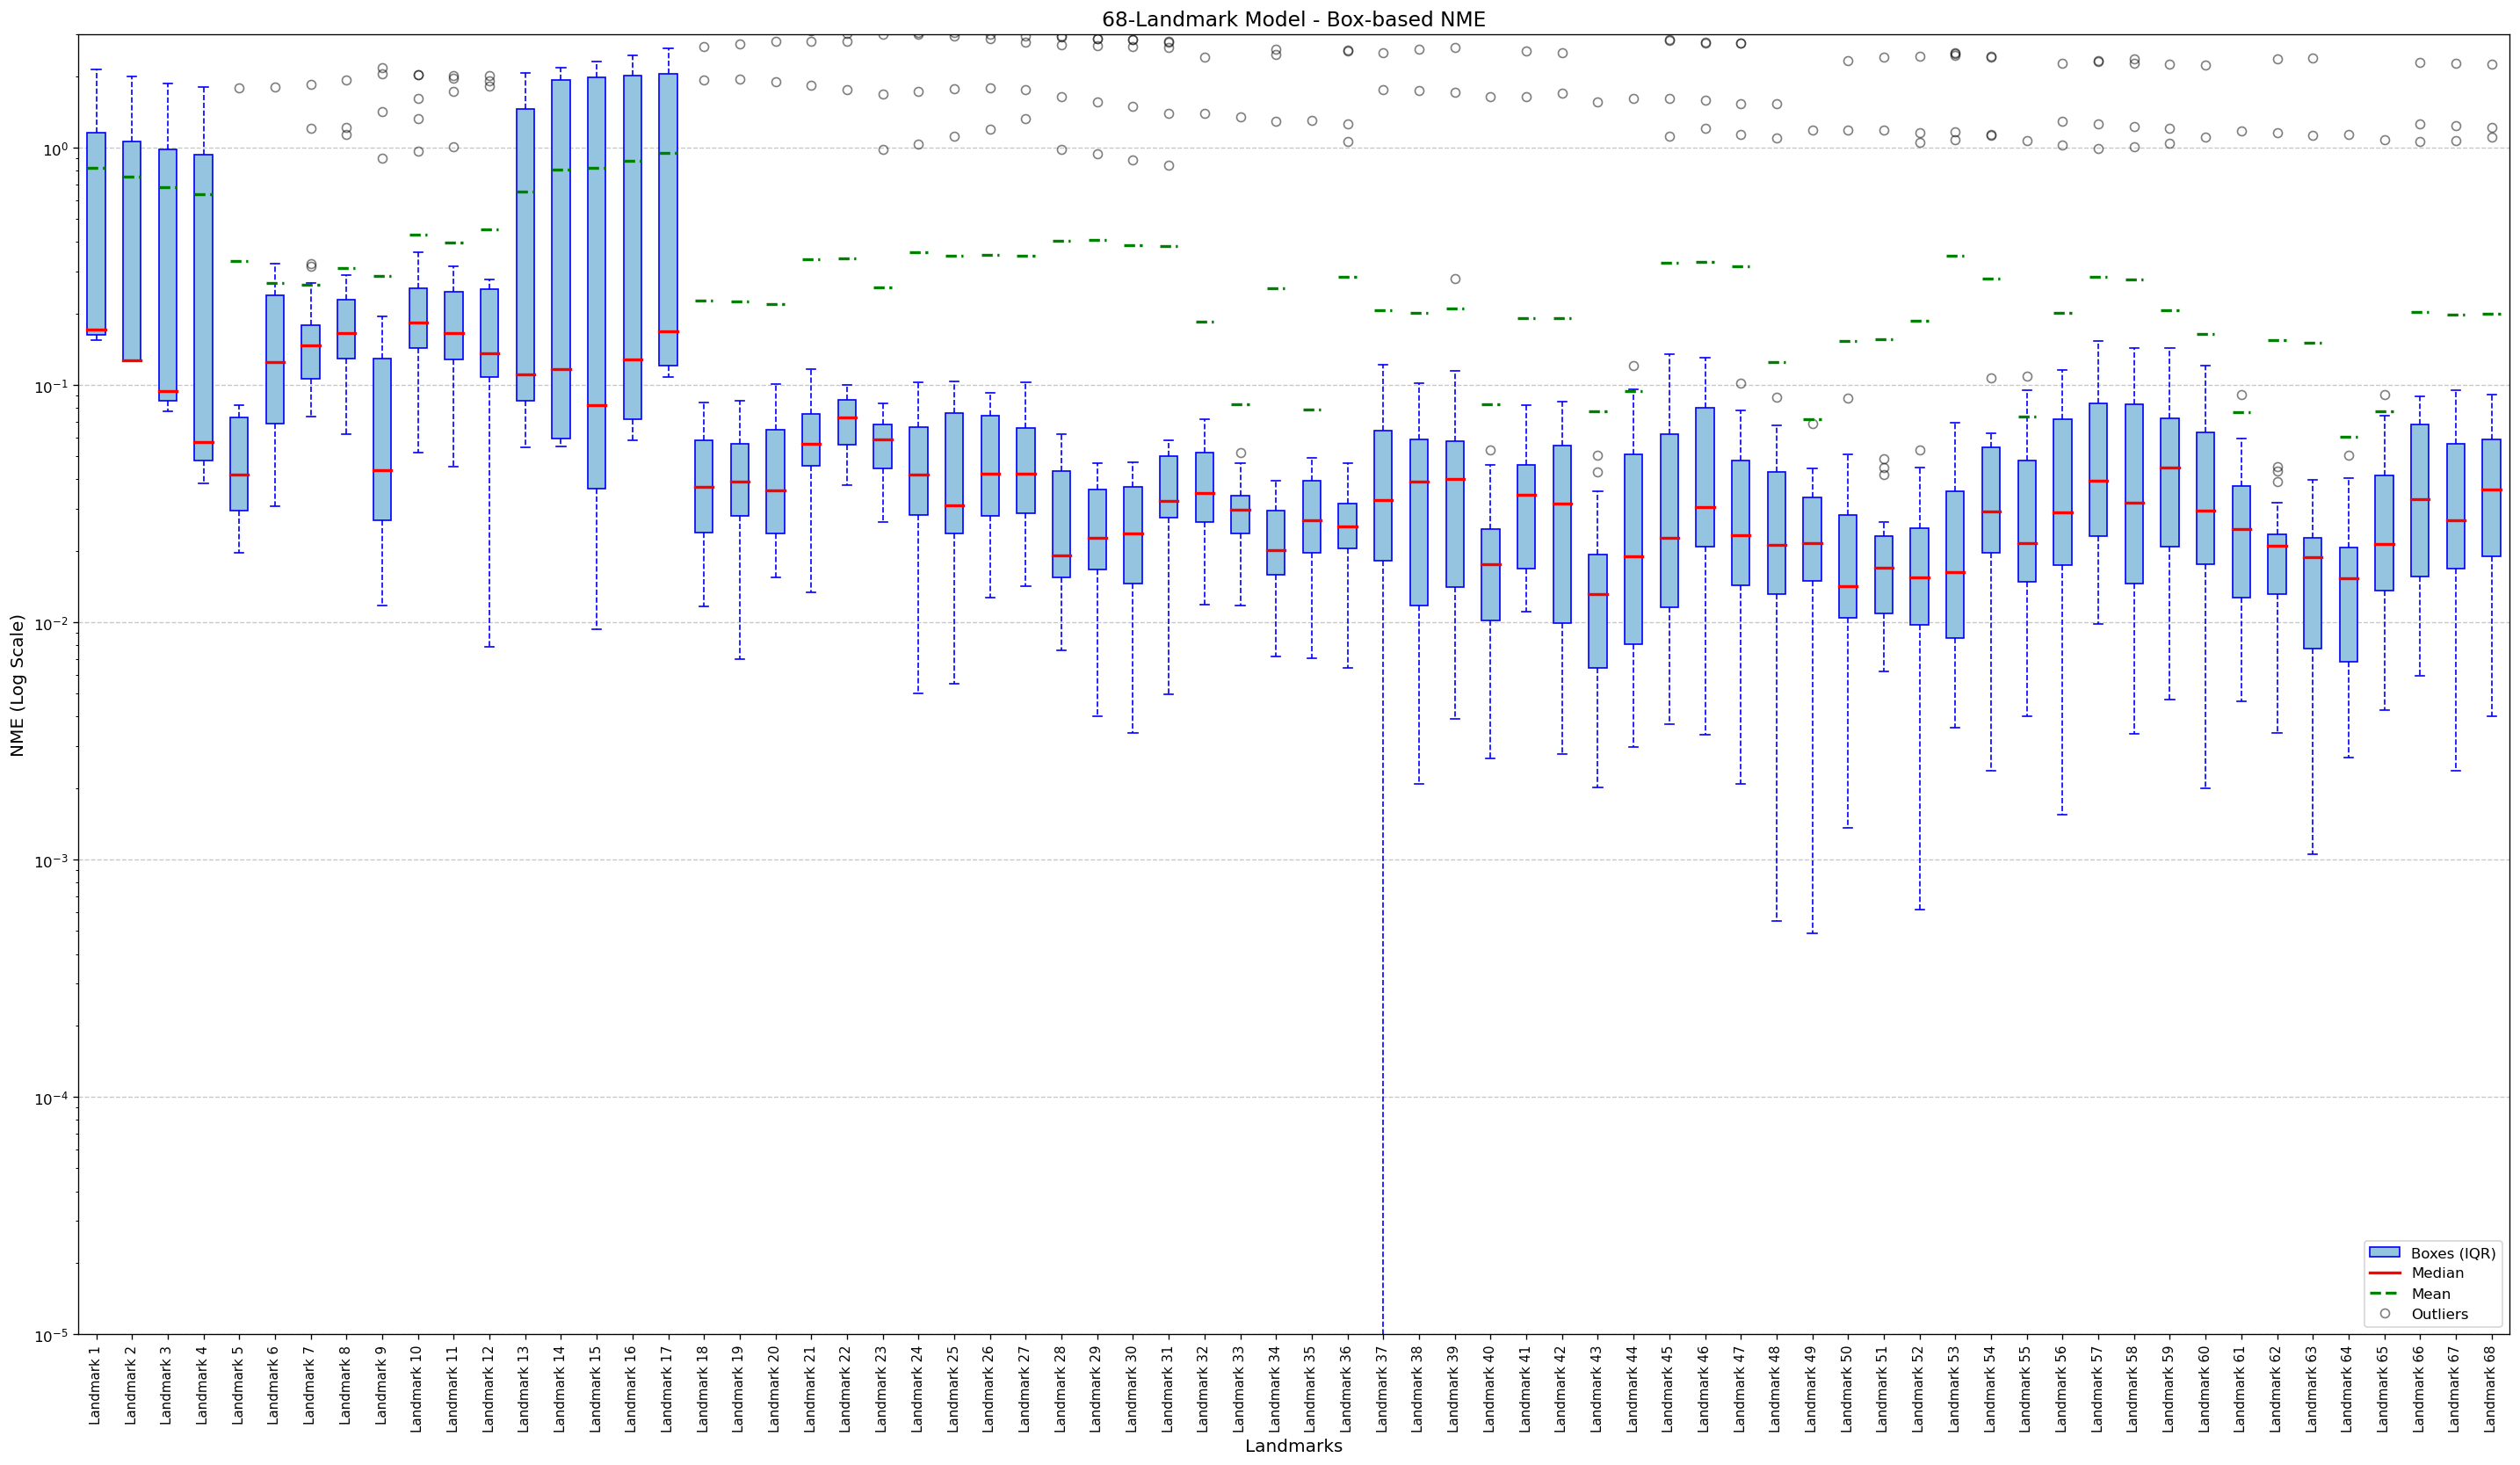

In [76]:
# Example usage for a 68-landmark pipeline
pred_dir_dlib = "/Users/jocareher/Downloads/dlib_predictions/labels"
gt_dir = "/Users/jocareher/Downloads/baby_face_72_311/labels"
results_dlib = evaluate_nme(
    pred_dir=pred_dir_dlib,
    gt_dir=gt_dir,
    num_landmarks=68,
    floats_per_lmk_pred=2,  # (x, y) predictions
    floats_per_lmk_gt=2,    # (x, y) ground truth
    allow_multi_face=False,  # possibly multiple lines per file
    left_eye_idx=36,
    right_eye_idx=45
)

# Print detection summary
print(f"DLIB: Average NME (IOD): {results_dlib['avg_nme_iod']}")
print(f"DLIB: Average NME (BOX): {results_dlib['avg_nme_box']}")
print(f"DLIB: Valid Detections: {results_dlib['valid_detections']} out of {results_dlib['total_files']} "
        f"({results_dlib['detection_rate']:.2f}%)")

# Print per-landmark valid counts
print_valid_counts_per_landmark(results_dlib["valid_counts_per_landmark"])

# If needed, plot the boxplot
plot_nme_boxplot(
    nme_per_landmark=results_dlib["nme_per_landmark"],
    num_landmarks=68,
    y_min=1e-5,
    y_max=3.0,
    title="68-Landmark Model - Box-based NME"
)


MediaPipe: Average NME (BOX): 0.2646
MediaPipe: Valid Detections: 203 out of 311 (65.27%)
Landmark 1: 49 values
Landmark 2: 49 values
Landmark 3: 49 values
Landmark 4: 47 values
Landmark 5: 51 values
Landmark 6: 74 values
Landmark 7: 140 values
Landmark 8: 157 values
Landmark 9: 189 values
Landmark 10: 167 values
Landmark 11: 145 values
Landmark 12: 96 values
Landmark 13: 71 values
Landmark 14: 61 values
Landmark 15: 60 values
Landmark 16: 60 values
Landmark 17: 60 values
Landmark 18: 141 values
Landmark 19: 152 values
Landmark 20: 162 values
Landmark 21: 181 values
Landmark 22: 185 values
Landmark 23: 182 values
Landmark 24: 183 values
Landmark 25: 177 values
Landmark 26: 166 values
Landmark 27: 158 values
Landmark 28: 197 values
Landmark 29: 197 values
Landmark 30: 199 values
Landmark 31: 200 values
Landmark 32: 151 values
Landmark 33: 154 values
Landmark 34: 193 values
Landmark 35: 163 values
Landmark 36: 159 values
Landmark 37: 157 values
Landmark 38: 164 values
Landmark 39: 158 va

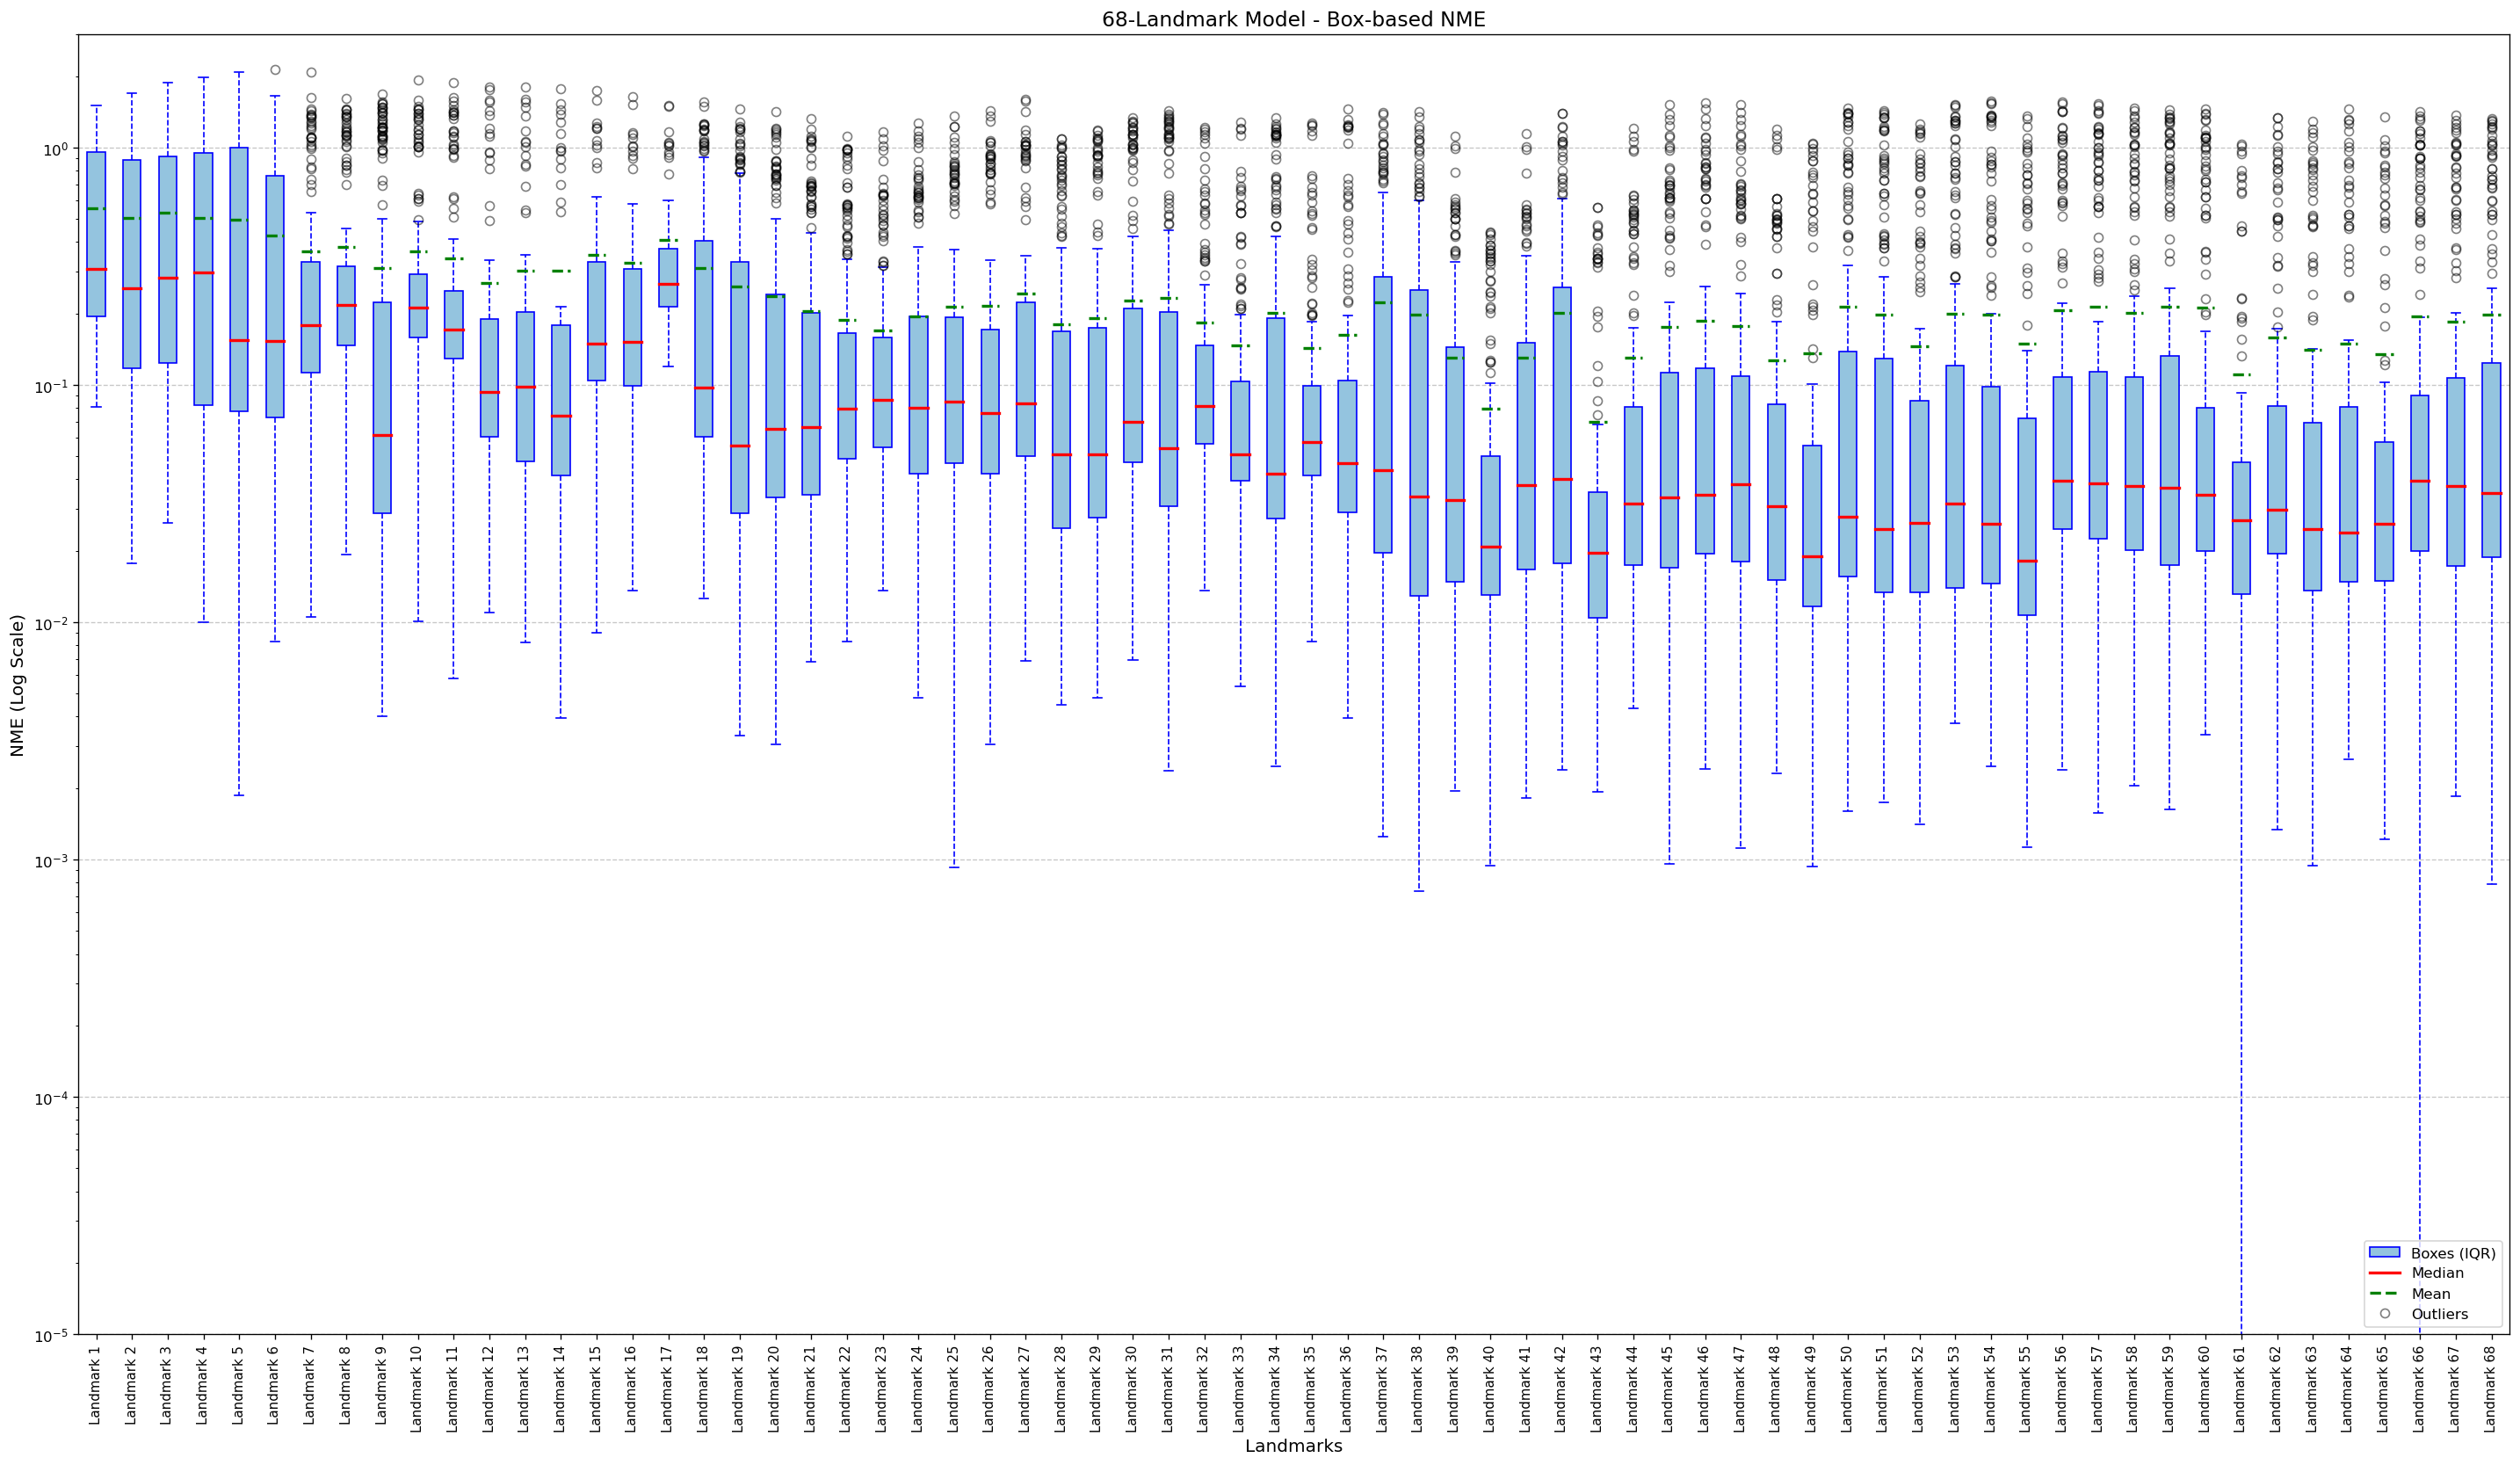

In [68]:
# Example usage for a 68-landmark pipeline
pred_dir_mediapipe = "/Users/jocareher/Downloads/mediapipe_68_lmks_predictions/labels"
results_mediapipe = evaluate_nme(
    pred_dir=pred_dir_mediapipe,
    gt_dir=gt_dir,
    num_landmarks=68,
    floats_per_lmk_pred=2,  # (x, y) predictions
    floats_per_lmk_gt=2,    # (x, y) ground truth
    allow_multi_face=False,  # possibly multiple lines per file
    left_eye_idx=36,
    right_eye_idx=45
)

# Print detection summary
print(f"MediaPipe: Average NME (BOX): {results_mediapipe['avg_nme_box']:.4f}")
print(f"MediaPipe: Valid Detections: {results_mediapipe['valid_detections']} out of {results_mediapipe['total_files']} "
        f"({results_mediapipe['detection_rate']:.2f}%)")

# Print per-landmark valid counts
print_valid_counts_per_landmark(results_mediapipe["valid_counts_per_landmark"])

# If needed, plot the boxplot
plot_nme_boxplot(
    nme_per_landmark=results_mediapipe["nme_per_landmark"],
    num_landmarks=68,
    y_min=1e-5,
    y_max=3.0,
    title="68-Landmark Model - Box-based NME"
)   

YOLO-pose: Average NME (IOD): None
YOLO-pose: Average NME (BOX): 0.5435742801654524
YOLO-pose: Valid Detections: 201 out of 311 (64.63%)
Landmark 1: 66 values
Landmark 2: 66 values
Landmark 3: 65 values
Landmark 4: 63 values
Landmark 5: 68 values
Landmark 6: 86 values
Landmark 7: 144 values
Landmark 8: 156 values
Landmark 9: 194 values
Landmark 10: 149 values
Landmark 11: 125 values
Landmark 12: 85 values
Landmark 13: 65 values
Landmark 14: 57 values
Landmark 15: 55 values
Landmark 16: 56 values
Landmark 17: 56 values
Landmark 18: 143 values
Landmark 19: 149 values
Landmark 20: 157 values
Landmark 21: 169 values
Landmark 22: 172 values
Landmark 23: 154 values
Landmark 24: 157 values
Landmark 25: 152 values
Landmark 26: 146 values
Landmark 27: 139 values
Landmark 28: 194 values
Landmark 29: 195 values
Landmark 30: 198 values
Landmark 31: 198 values
Landmark 32: 144 values
Landmark 33: 142 values
Landmark 34: 189 values
Landmark 35: 139 values
Landmark 36: 135 values
Landmark 37: 154 val

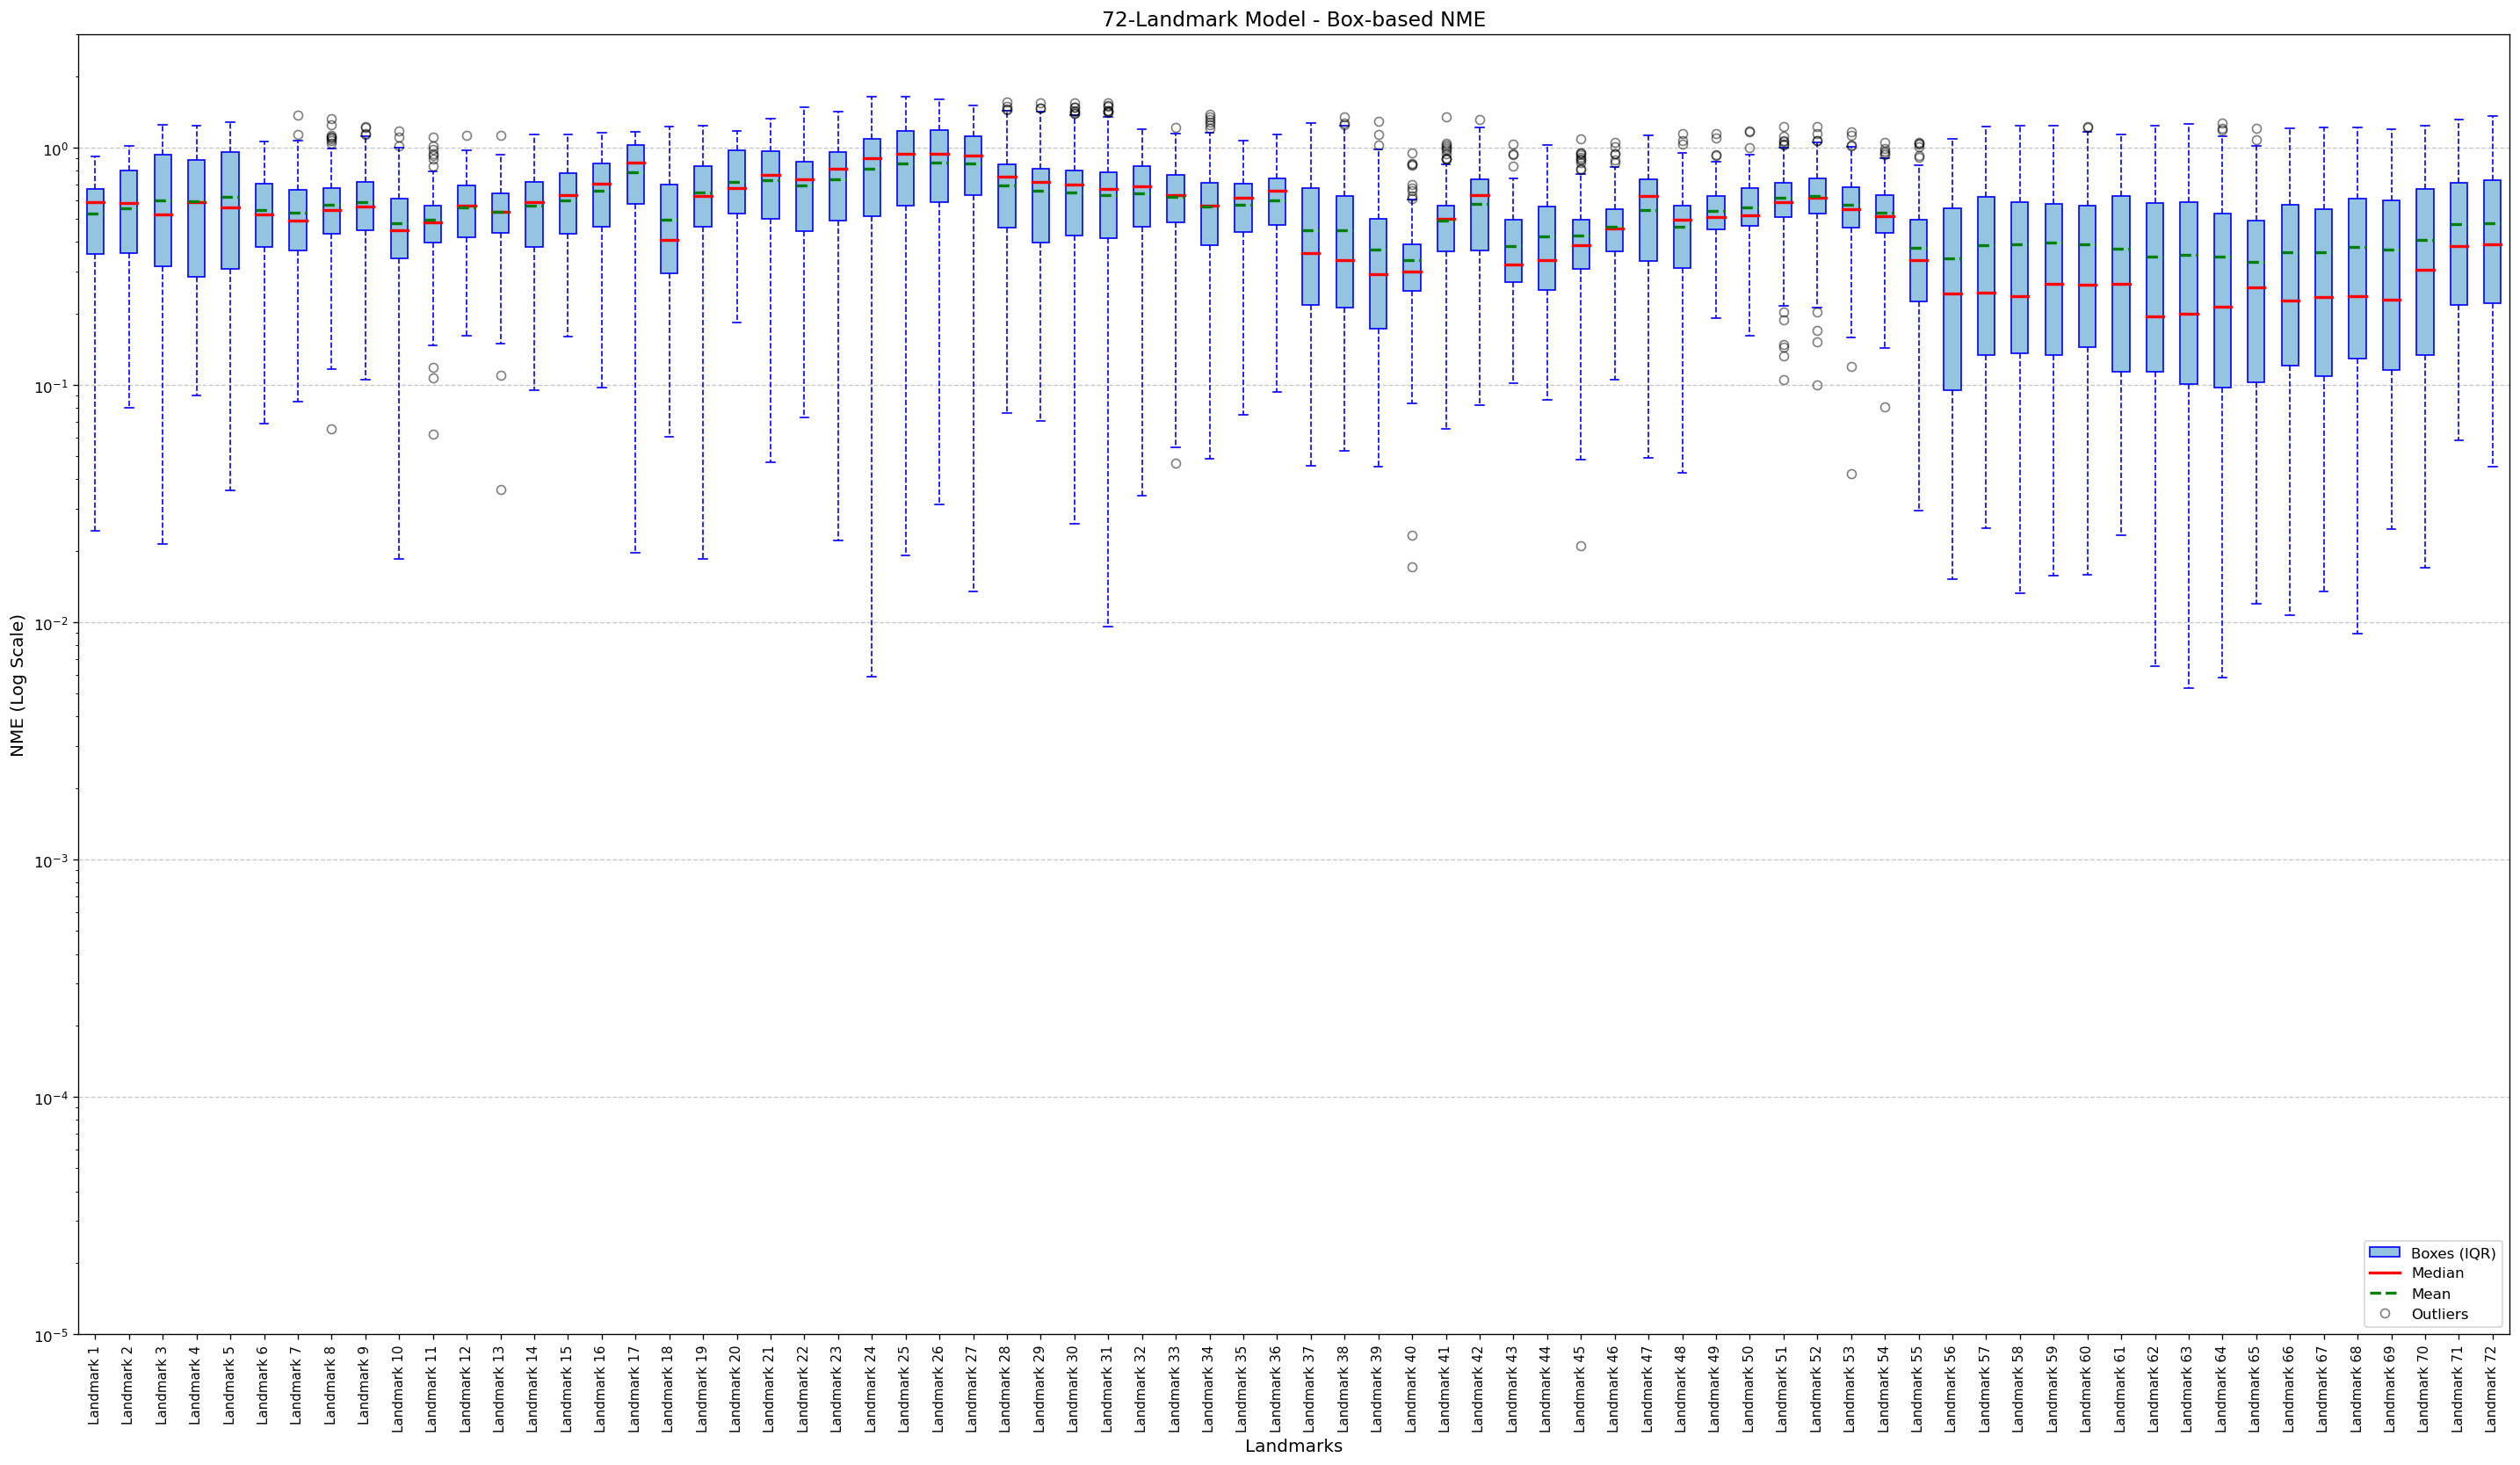

In [69]:
# Example usage for a 72-landmark pipeline (with x,y,visibility predictions)
pred_dir_yolo = "/Users/jocareher/Downloads/perspective_obb_72/labels"
# Suppose left eye is index 35, right eye is index 44, and a custom mapping is needed
mapping = create_landmark_mapping()  # or create_landmark_mapping()

results_yolo = evaluate_nme(
    pred_dir=pred_dir_yolo,
    gt_dir=gt_dir,
    num_landmarks=72,
    floats_per_lmk_pred=3,    # model has (x, y, visibility)
    floats_per_lmk_gt=2,      # ground truth has (x, y)
    allow_multi_face=False,   # likely only one line per file
    left_eye_idx=35,
    right_eye_idx=44,
    mapping=mapping
)

print(f"YOLO-pose: Average NME (IOD): {results_yolo['avg_nme_iod']}")
print(f"YOLO-pose: Average NME (BOX): {results_yolo['avg_nme_box']}")
print(f"YOLO-pose: Valid Detections: {results_yolo['valid_detections']} out of {results_yolo['total_files']} "
        f"({results_yolo['detection_rate']:.2f}%)")

# Print per-landmark valid counts
print_valid_counts_per_landmark(results_yolo["valid_counts_per_landmark"])

# Boxplot if desired
plot_nme_boxplot(
    nme_per_landmark=results_yolo["nme_per_landmark"],
    num_landmarks=72,
    y_min=1e-5,
    y_max=3.0,
    title="72-Landmark Model - Box-based NME"
)
